In [3]:
"""
Goal: 
This notebook is an accumulation of the work done in the manuscript "Machine Learning-based Bioactivity Classification of Natural Products Using LC-MS/MS Metabolomics" by Brittin et al.in relation to the 23 Bioactive Class Multiclassifier. 
It computes every experiment shown in the manuscript and provides the code to do replicate the experiments.

Steps:
1. Import fingerprint matrix data for training/testing, false positive evaluation, GNPS experimental testing, and real-world bacterial extracts.
2. Initiate a variety of model types
3. Train each model type on 80% of the training data
4. Evaluate the ROC-AUC score for each model type on the 20% held-out data
5. Test each model type on 20% held-out data
6. Test each model on GNPS testing data
7. Evaluate the false positive rate for each model type on the random GNPS spectra
8. Evaluate the models performance on the real-world bacterial extracts

Author: Nathan Brittin 
Date: September 18th 2024 (09-08-2024)

"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output. These warnings are not important for the user.
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [4]:
def make_training_testing(training_testing):
    # Make the training and testing sets using the training_testing data
    X = training_testing.copy()
    X.reset_index(drop=True)
    X = X.drop(['CID'], axis=1)
    y = X.pop('Parent Class')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def make_gnps_testing(gnps_df):
    # Make the gnps testing set using the gnps_df data
    X = gnps_df.copy()
    X.drop(columns=['Unnamed: 0'], inplace=True)
    X.set_index('CID', inplace=True)
    X.reset_index(drop=True)
    y = X.pop('Parent Class')
    return X, y

def prepare_negative_data(negatives_path):
    negatives_df = pd.read_pickle(negatives_path)
    negatives_df.drop(columns=["SMILES", "Positive"], inplace=True)
    # Insert Parent Class column as the second column
    negatives_df.insert(1, "Parent Class", "Negatives")
    # Make column headers strings
    negatives_df.columns = negatives_df.columns.astype(str)
    return negatives_df

def prepare_fpr_data(fpr_path):
    new_fpr_df = pd.read_csv(fpr_path, sep='\t')
    new_fpr_df.set_index('CID', inplace=True)
    new_fpr_df.columns = new_fpr_df.columns.astype(int)
    return new_fpr_df

def combine_data_with_neg(training_testing, negatives_df):
    # Combine the training_testing data with the negative data
    combined_df = pd.concat([training_testing, negatives_df], axis=0, ignore_index=True)
    combined_df.reset_index(drop=True, inplace=True)
    return combined_df

def prepare_bacterial_extract_fingerprints(bacterial_extract_path):
    bacterial_extract_fingerprints_df = pd.read_csv(bacterial_extract_path)
    bacterial_extract_fingerprints_df.rename(columns={"Unnamed: 0": "CID"}, inplace=True)
    bacterial_extract_fingerprints_df.set_index("CID", inplace=True)
    bacterial_extract_fingerprints_df.columns = [int(i) for i in bacterial_extract_fingerprints_df.columns]
    return bacterial_extract_fingerprints_df

def encode_labels(y_train, y_test, y_gnps):
    """
    Encode the labels for the training/testing data
    """
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    y_gnps = le.transform(y_gnps)
    return y_train, y_test, y_gnps

def decode_labels(y_train, x, round=False):
    """
    Decode the labels for the training/testing data
    """
    le = LabelEncoder()
    le.fit(y_train)
    if round:
        x = np.rint(x).astype(int)
    x = le.inverse_transform(x)
    return x

In [3]:
training_testing_path = "*/Labelled_23_Class_Molecular_Fingerprint_Matrix.tsv"
negatives_path = "*/Negative_Train-Test_Fingerprint_Matrix.tsv"
gnps_positive_path = "*/GNPS_23_Drug_Class_Fingerprints_Matrix.tsv"
gnps_negative_path = "*/GNPS_Negatives_Fingerprint_Matrix.tsv"
fpr_evaluation_path = "C:/Users/nbrittin/Desktop/Antifungal_Multiclassifier/Manually_Curated_Compounds/False Positive Rate Evaluation/Random_Fingerprints/Random_GNPS_Fingerprints.tsv"
bacterial_extract_fingerprint_path = "C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/Fingerprints/Known_polyene_10_07262023_5.8.0_fingerprint_matrix.csv"
bacterial_extract_canopus_predictions = "C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/SIRIUS5.8.0/canopus_formula_summary_all.tsv"

# Import and Prepare Datasets
training_testing_df = pd.read_csv(training_testing_path, sep='\t')
negative_df = prepare_negative_data(negatives_path)
training_testing_df = combine_data_with_neg(training_testing_df, negative_df)
fpr_dataset_df = prepare_fpr_data(fpr_evaluation_path)

# Split the training data into a Train and Test set (80/20 split)
X_train, X_test, y_train, y_test = make_training_testing(training_testing_df)

# Combine the positive and negative GNPS data
gnps_positive_df = pd.read_csv(gnps_positive_path, sep='\t')
gnps_negative_df = pd.read_csv(gnps_negative_path, sep='\t')
gnps_df = pd.concat([gnps_positive_df, gnps_negative_df], axis=0, ignore_index=True)

# Split the GNPS data into X data matrix and y labels
X_gnps, y_gnps = make_gnps_testing(gnps_df)

# Simulataneously encode the labels numerically
y_train_encoded, y_test_encoded, y_gnps_encoded = encode_labels(y_train, y_test, y_gnps)

# Import bacterial fraction fingerprint matrix and CANOPUS predictions:
bacterial_extract_fingerprints_df = prepare_bacterial_extract_fingerprints(bacterial_extract_fingerprint_path)
canopus_polyene_known_formula_tsv = pd.read_csv(bacterial_extract_canopus_predictions, sep='\t')

print(f"Training and Testing Data Shape: {training_testing_df.shape}")
print(f"Negative Data Shape: {negative_df.shape}")
print(f"Combined Data Shape: {training_testing_df.shape}")
print(f"Training Data Shape: {X_train.shape}; Testing Data Shape: {X_test.shape}")
print(f"GNPS Data Shape: {gnps_df.shape}")
print(f"GNPS Testing Data Shape: {X_gnps.shape}")

Training and Testing Data Shape: (8521, 3880)
Negative Data Shape: (2778, 3880)
Combined Data Shape: (11299, 3880)
Training Data Shape: (9039, 3878); Testing Data Shape: (2260, 3878)
GNPS Data Shape: (4050, 3881)
GNPS Testing Data Shape: (4050, 3879)


In [7]:
# Initiate all model types and train them on the 80% training data

"""
WARNING: 
These models can take a signficiant amount of time to run.
Most of the models are set to train multi-processed, which uses all available cpu cores on the computer.
However, the single core models can take a long time to run and with fewer core the time will increase.

Example:
CPU with 52 processor took 4 minutes to train all models.
"""

models_list = [
            linear_model.RidgeClassifier(random_state=42), 
            linear_model.Perceptron(random_state=42, n_jobs=-1), 
            linear_model.PassiveAggressiveClassifier(random_state=42, n_jobs=-1), 
            linear_model.SGDClassifier(random_state=42, n_jobs=-1), 
            linear_model.LogisticRegression(random_state=42, n_jobs=-1),
            neighbors.KNeighborsClassifier(n_jobs=-1), 
            tree.DecisionTreeClassifier(random_state=42), 
            svm.SVC(random_state=42, decision_function_shape='ovr'),
            neural_network.MLPClassifier(random_state=42, hidden_layer_sizes=(140,), early_stopping=True)]

for model in tqdm(models_list):
    model.fit(X_train, y_train_encoded)

100%|██████████| 9/9 [04:09<00:00, 27.77s/it]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Evaluating the performance and learning of each model type on the 20% held-out data
# The metrics being used are Accuracy, Precision, Recall, F1, and Matthews Correlation Coefficient (MCC)

training_results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'MCC'])
for model in tqdm(models_list):
    # Model predictions
    predictions = model.predict(X_test)
    predictions = np.rint(predictions).astype(int) # Round the encoded predictions to integers, not necessary for all models but avoids issues with some predictions being floats.
    # Model metrics
    accuracy = accuracy_score(y_test_encoded, predictions)
    precision = precision_score(y_test_encoded, predictions, average='weighted', zero_division=0) # zero_division=0 is used to avoid division by zero errors. The average='weighted' is used to account for class imbalance.
    recall = recall_score(y_test_encoded, predictions, average='weighted', zero_division=0) # zero_division=0 is used to avoid division by zero errors. The average='weighted' is used to account for class imbalance.
    f1 = f1_score(y_test_encoded, predictions, average='weighted', zero_division=0) # zero_division=0 is used to avoid division by zero errors. The average='weighted' is used to account for class imbalance.
    mcc = matthews_corrcoef(y_test_encoded, predictions)
    # Compile metrics into the overall results.
    model_name = model.__class__.__name__
    temp_df = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'MCC': mcc}, index=[0])
    training_results_df = pd.concat([training_results_df, temp_df], axis=0, ignore_index=True)

# Sort the results by MCC score to see the best performing models.
training_results_df = training_results_df.sort_values(by=['MCC'], ascending=False)
print("Testing results for each model type:")
display(training_results_df)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\nbrittin\AppData\Local\Temp/ipykernel_28852/530265842.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_results_df = pd.concat([training_results_df, temp_df], axis=0, ignore_index=True)
100%|██████████| 9/9 [00:28<00:00,  3.19s/it]

Testing results for each model type:


,Model,Accuracy,Precision,Recall,F1,MCC
4,LogisticRegression,0.985841,0.986065,0.985841,0.985834,0.984164
0,RidgeClassifier,0.983186,0.983371,0.983186,0.983179,0.981180
2,PassiveAggressiveClassifier,0.982301,0.982491,0.982301,0.982308,0.980160
1,Perceptron,0.980088,0.980444,0.980088,0.980086,0.977718
7,SVC,0.978761,0.979231,0.978761,0.978747,0.976262
3,SGDClassifier,0.976549,0.977551,0.976549,0.976526,0.973754
8,MLPClassifier,0.969469,0.970312,0.969469,0.969479,0.965962
5,KNeighborsClassifier,0.947345,0.951419,0.947345,0.946815,0.942344
6,DecisionTreeClassifier,0.887611,0.890651,0.887611,0.888402,0.874302


In [9]:
# Evaluating the performance and learning of each model type on the 1,256 GNPS Fingerprint testing data
# The metrics being used are Accuracy, Precision, Recall, F1, and Matthews Correlation Coefficient (MCC)

gnps_results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'MCC'])
for model in tqdm(models_list):
    # Model predictions
    predictions = model.predict(X_gnps)
    predictions = np.rint(predictions).astype(int) # Round the encoded predictions to integers, not necessary for all models but avoids issues with some predictions being floats.
    # Model metrics
    accuracy = accuracy_score(y_gnps_encoded, predictions)
    precision = precision_score(y_gnps_encoded, predictions, average='weighted', zero_division=0) # zero_division=0 is used to avoid division by zero errors. The average='weighted' is used to account for class imbalance.
    recall = recall_score(y_gnps_encoded, predictions, average='weighted', zero_division=0) # zero_division=0 is used to avoid division by zero errors. The average='weighted' is used to account for class imbalance.
    f1 = f1_score(y_gnps_encoded, predictions, average='weighted', zero_division=0) # zero_division=0 is used to avoid division by zero errors. The average='weighted' is used to account for class imbalance.
    mcc = matthews_corrcoef(y_gnps_encoded, predictions)
    # Compile metrics into the overall results.
    model_name = model.__class__.__name__
    temp_df = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'MCC': mcc}, index=[0])
    gnps_results_df = pd.concat([gnps_results_df, temp_df], axis=0, ignore_index=True)

# Sort the results by MCC score to see the best performing models.
gnps_results_df = gnps_results_df.sort_values(by=['MCC'], ascending=False)
print("Testing results for each model type on GNPS data:")
display(gnps_results_df)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\nbrittin\AppData\Local\Temp/ipykernel_28852/3195357986.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gnps_results_df = pd.concat([gnps_results_df, temp_df], axis=0, ignore_index=True)
100%|██████████| 9/9 [00:49<00:00,  5.47s/it]

Testing results for each model type on GNPS data:


,Model,Accuracy,Precision,Recall,F1,MCC
7,SVC,0.935802,0.946922,0.935802,0.938867,0.879116
3,SGDClassifier,0.903210,0.924909,0.903210,0.910240,0.821806
0,RidgeClassifier,0.890864,0.922945,0.890864,0.900930,0.810138
2,PassiveAggressiveClassifier,0.887901,0.914407,0.887901,0.896530,0.798511
8,MLPClassifier,0.878025,0.922796,0.878025,0.891939,0.796252
4,LogisticRegression,0.885185,0.910385,0.885185,0.893468,0.795832
1,Perceptron,0.867654,0.910417,0.867654,0.880493,0.769399
5,KNeighborsClassifier,0.840000,0.911609,0.840000,0.861096,0.749395
6,DecisionTreeClassifier,0.738765,0.835042,0.738765,0.775078,0.578345


In [12]:
# Evaluating the performance and learning of each model type on the FPR dataset with random GNPS spectra as a control on prediction promescuity.
# The metrics being used are Accuracy, Precision, Recall, F1, and Matthews Correlation Coefficient (MCC)

new_FPR_results_df = pd.DataFrame(columns=['Model', 'False Positive Rate', 'Number of False Positives', 'Number of True Negatives'])
FPR_counts = pd.DataFrame()
for model in tqdm(models_list):
    # Model predictions
    predictions_encoded = model.predict(fpr_dataset_df)
    predictions = decode_labels(y_train, predictions_encoded, round=True) # Decode the predictions to the original string labels
    predictions = pd.DataFrame(predictions) # Convert the predictions to a DataFrame
    # Calculating the false positive rate (FPR)
    total_pred = predictions.shape[0]
    counts = predictions.value_counts()
    counts_df = pd.DataFrame(counts)
    counts_df = counts_df.T
    # Compile the counts into the overall results.
    FPR_counts = pd.concat([FPR_counts, counts_df], axis=0, ignore_index=True)
    num_negatives = predictions.value_counts()['Negatives'] # Count the number of negatives
    num_positives = predictions.shape[0] - num_negatives # Get the number of false positives
    false_positive_rate = num_positives / total_pred
    # Compile the FPR into the overall results.
    model_name = str(model).split('(')[0]
    temp_df = pd.DataFrame({'Model': model_name, 'False Positive Rate': false_positive_rate, 'Number of False Positives': num_positives, 'Number of True Negatives': num_negatives}, index=[0])
    new_FPR_results_df = pd.concat([new_FPR_results_df, temp_df], axis=0, ignore_index=True)

new_FPR_results_df = new_FPR_results_df.sort_values(by=['False Positive Rate'], ascending=True)
print("False positive rate for each model type on new random spectra:")
display(new_FPR_results_df)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\nbrittin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RidgeClassifier was fitted with feature names
  warnings.warn(
C:\Users\nbrittin\AppData\Local\Temp/ipykernel_28852/2428849504.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_FPR_results_df = pd.concat([new_FPR_results_df, temp_df], axis=0, ignore_index=True)
C:\Users\nbrittin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Perceptron was

False positive rate for each model type on new random spectra:


,Model,False Positive Rate,Number of False Positives,Number of True Negatives
7,SVC,0.055279,522,8921
3,SGDClassifier,0.086519,817,8626
2,PassiveAggressiveClassifier,0.100392,948,8495
4,LogisticRegression,0.107169,1012,8431
0,RidgeClassifier,0.116912,1104,8339
1,Perceptron,0.127820,1207,8236
8,MLPClassifier,0.141163,1333,8110
5,KNeighborsClassifier,0.182357,1722,7721
6,DecisionTreeClassifier,0.227152,2145,7298


In [36]:
# Make a dataframe with the id and NPC#class columns
canopus_id_class_df = pd.DataFrame(canopus_polyene_known_formula_tsv, columns=['id', 'NPC#class', "molecularFormula"])
canopus_id_class_df.rename(columns = {'id':'CID'}, inplace = True)
canopus_id_class_df.set_index("CID", inplace=True)
canopus_id_class_df["Sample Name"] = ""
for index, row in canopus_id_class_df.iterrows():
    canopus_id_class_df.at[index, "Sample Name"] = re.search(r'[0-9]+_([A-Z,a-z]+[0-9]+[-,_][A-Z][0-9]+)', row.name).group(1)

# For each unique sample name, count the number of polyenes identified by CANOPUS
sample_names = canopus_id_class_df["Sample Name"].unique()
sample_name_counts = {}
for sample in sample_names:
    temp_df = canopus_id_class_df[canopus_id_class_df["Sample Name"] == sample]
    sample_name_counts[sample] = len(temp_df[temp_df["NPC#class"] == "Polyene macrolides"])
# print(sample_name_counts) 

Bacterial Extract Fingerprints: (3545, 3878)


In [37]:
canopus_id_class_df["Sample Name"] = ""
for index, row in canopus_id_class_df.iterrows():
    canopus_id_class_df.at[index, "Sample Name"] = re.search(r'[0-9]+_([A-Z,a-z]+[0-9]+[-,_][A-Z][0-9]+)', row.name).group(1)
# display(canopus_id_class_df.head())

# For each unique sample name, count the number of polyenes identified by CANOPUS
sample_names = canopus_id_class_df["Sample Name"].unique()
sample_name_counts = {}
for sample in sample_names:
    temp_df = canopus_id_class_df[canopus_id_class_df["Sample Name"] == sample]
    sample_name_counts[sample] = len(temp_df[temp_df["NPC#class"] == "Polyene macrolides"])
# print(sample_name_counts) 

In [38]:
# Disable warnings
warnings.filterwarnings("ignore")

In [39]:
bacterial_extract_hits_df = pd.DataFrame(columns=["Model", "Number of Hits"])
bacterial_extract_predictions_df = pd.DataFrame()

for model in tqdm(models_list):
    model_name = model.__class__.__name__
    y_pred = model.predict(bacterial_extract_fingerprints_df)
    y_pred_decoded = decode_labels(y_train, y_pred, round=True)
    prediction_value_counts = pd.DataFrame(y_pred_decoded).value_counts()
    polyene_hits = prediction_value_counts["Polyene"]
    temp_df = pd.DataFrame({"Model": model_name, "Number of Hits": polyene_hits}, index=[0])
    bacterial_extract_hits_df = pd.concat([bacterial_extract_hits_df, temp_df], axis=0, ignore_index=True)
    bacterial_extract_predictions_df[model_name] = y_pred_decoded

bacterial_fingerprints_index = bacterial_extract_fingerprints_df.index
bacterial_extract_predictions_df.insert(0, "CID", bacterial_fingerprints_index)
bacterial_extract_predictions_df.set_index("CID", inplace=True)
bacterial_extract_hits_df = bacterial_extract_hits_df.sort_values(by=["Number of Hits"], ascending=False)
print("Number of polyene hits for each model type on the bacterial extracts:")
display(bacterial_extract_hits_df)
display(bacterial_extract_predictions_df.head())

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:42<00:00,  4.78s/it]

Number of polyene hits for each model type on the bacterial extracts:


,Model,Number of Hits
5,KNeighborsClassifier,164
1,Perceptron,135
8,MLPClassifier,121
4,LogisticRegression,114
2,PassiveAggressiveClassifier,107
0,RidgeClassifier,100
6,DecisionTreeClassifier,100
7,SVC,92
3,SGDClassifier,48


,RidgeClassifier,Perceptron,PassiveAggressiveClassifier,SGDClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,MLPClassifier
CID,,,,,,,,,
"C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/SIRIUS5.8.0\100_SID11285_E8_MSMS_1-A,3_01_25776_62_C24H38O7_[M_K]__0",Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives
"C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/SIRIUS5.8.0\100_SID11285_E8_MSMS_1-A,3_01_25776_62_C27H34O6_[M_Na]__1",Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives
"C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/SIRIUS5.8.0\100_SID11285_E8_MSMS_1-A,3_01_25776_62_C29H32O6_[M_H]__2",Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives
"C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/SIRIUS5.8.0\101_SID11285_E8_MSMS_1-A,3_01_25776_63_C19H31N6O2_[M_H]__3",Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives
"C:/Users/nbrittin/Desktop/Polyene_Identification_Project/Experiments/Identification_of_Known_Polyene_Spectra/Bacterial Extracts/Bacterial_extracts_polyene/SIRIUS5.8.0\101_SID11285_E8_MSMS_1-A,3_01_25776_63_C21H33N3O3_[M_H]__4",Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives,Negatives


In [29]:
import re
# Get the index of the fingerprint matrix
samples_cid = bacterial_extract_fingerprints_df.index
samples_names = set()
for cid in samples_cid:
    try:
        name = re.search(r"[0-9]+_([A-Z,a-z]+[0-9]+[-,_][A-Z][0-9]+)", cid).group(1)
    except:
        print(f"Error with CID: {cid}")
    samples_names.add(name)
samples_cid = bacterial_extract_fingerprints_df.index
samples_names = set()
for cid in samples_cid:
    try:
        name = re.search(r"[0-9]+_([A-Z,a-z]+[0-9]+[-,_][A-Z][0-9]+)", cid).group(1)
    except:
        print(f"Error with CID: {cid}")
    samples_names.add(name)
model_names = list(bacterial_extract_predictions_df.columns)
bacterial_sample_hits_df = pd.DataFrame(index=list(samples_names), columns=model_names, data=0)
for index, row in bacterial_extract_predictions_df.iterrows():
    name = re.search(r"[0-9]+_([A-Z,a-z]+[0-9]+[-,_][A-Z][0-9]+)", index).group(1)
    for model in models_list:
        model_name = str(model).split("(")[0]
        if row[model_name] == "Polyene":
            bacterial_sample_hits_df.at[name, model_name] += 1
bacterial_sample_hits_df.sort_index(inplace=True)
canopus_sample_counts_df = pd.DataFrame(columns=["Sample Name", "Number of Polyenes"])
for sample in sample_names:
    temp_df = pd.DataFrame({"Sample Name": [sample], "Number of Polyene Hits": [sample_name_counts[sample]]})
    canopus_sample_counts_df = pd.concat([canopus_sample_counts_df, temp_df], axis=0)

,RidgeClassifier,Perceptron,PassiveAggressiveClassifier,SGDClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,MLPClassifier
SID7982_E6,0,0,0,0,0,0,0,0,0
SID11285_G7,0,0,0,0,0,0,0,0,0
SID4915_G7,0,0,0,0,0,0,0,0,0
SID7982_E8,0,0,0,0,0,0,0,0,0
SID11285_E8,0,0,0,0,0,0,0,0,0


,RidgeClassifier,Perceptron,PassiveAggressiveClassifier,SGDClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,MLPClassifier
C905-E6,0,0,0,0,0,0,0,0,0
SID11285-B8,1,2,2,1,4,4,2,3,2
SID11285_A8,2,3,1,0,1,1,0,0,1
SID11285_B8,0,0,0,0,0,0,0,0,0
SID11285_E8,13,19,17,10,16,27,14,16,22


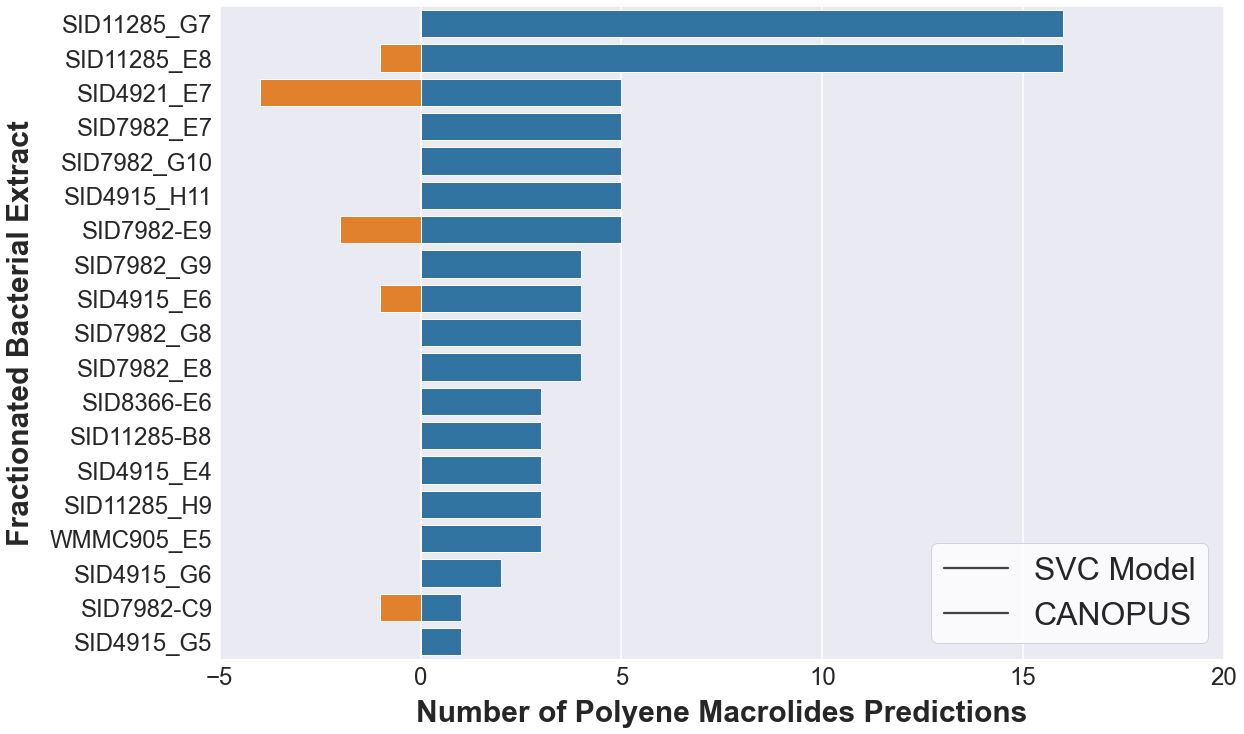

In [43]:
fig, (ax1) = plt.subplots(figsize=(18, 12))
bacterial_plot_df = bacterial_sample_hits_df.copy()
bacterial_plot_df["Sample Name"] = bacterial_plot_df.index
bacterial_plot_df.reset_index(drop=True, inplace=True)
bacterial_plot_df = bacterial_plot_df[bacterial_plot_df["SVC"] > 0]
bacterial_plot_df[bacterial_plot_df["Sample Name"] != sample]
bacterial_plot_df.sort_values(by="SVC", ascending=False, inplace=True)
canopus_plot_df = canopus_sample_counts_df.copy()
canopus_plot_df.reset_index(drop=True, inplace=True)
canopus_plot_df = canopus_plot_df[canopus_plot_df["Number of Polyene Hits"] > 0]
canopus_plot_df["Number of Polyene Hits"] = canopus_plot_df["Number of Polyene Hits"].astype(int) * -1
sns.set_style("whitegrid")
sns.barplot(x="SVC", y="Sample Name", data=bacterial_plot_df, ax=ax1)
sns.barplot(x="Number of Polyene Hits", y="Sample Name", data=canopus_plot_df, ax=ax1)
# Underline the title
# ax1.set_title("Best Model Outperforms CANOPUS in Polyene Detection", fontsize=28, fontname="Arial", pad=20, fontweight="bold")
# ax1.title.set_position([.4, 1.05])
ax1.set_xlabel("Number of Polyene Macrolides Predictions", fontsize=30, fontweight="bold", fontname="Arial", labelpad=10)
ax1.set_ylabel("Fractionated Bacterial Extract", fontsize=30, fontweight="bold", fontname="Arial", labelpad=15)
ax1.legend(["SVC", "CANOPUS"], loc="lower right", fontsize=18)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(-5, 20)
plt.grid(axis="x", linewidth=1.5)
plt.legend(["SVC Model", "CANOPUS"], loc="lower right", fontsize=32)
plt.show()